# BYOMBM Part 1: PBMetaD & FPS

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%run Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
calculator = Psi4Calculator(
        "HF",
        "STO-3G",
        log_directory=str(logs),
        scratch_directory=str(scratch.sub_directory("psi4")),
        qm_options={
            "GEOM_MAXITER": 500
        }
)

pbmetad_pool_size = 1000
fps_phase1_size = 500
fps_target_configs = 250


In [40]:
# calculator = Psi4Calculator(
#         "HF",
#         "STO-3G",
#         log_directory=str(logs),
#         scratch_directory=str(scratch.sub_directory("psi4")),
#         qm_options={
#             "GEOM_MAXITER": 500
#         }
# )

# pbmetad_pool_size = 100000
# fps_phase1_size = 30000
# fps_target_configs = 3000


In [15]:
# scratch.remove()
# restart.remove()
scratch.create()
restart.create()

## Setup

In [5]:
definition_my_fragment = read_fragment_definition(definitions.file("fragment_NH4+.def"))
definition_water = read_fragment_definition(definitions.file("H2O.def"))

definition_monomer = BasicCompoundDefinition()
definition_monomer.add_fragment(definition_my_fragment)
write_definition(definitions.file("monomer.xyz"), definition_monomer)

definition_monomer_H2O = BasicCompoundDefinition()
definition_monomer_H2O.add_fragment(definition_water)
write_definition(definitions.file("monomer_H2O.xyz"), definition_monomer_H2O)

definition_dimer = BasicCompoundDefinition()
definition_dimer.add_fragment(definition_my_fragment)
definition_dimer.add_fragment(definition_water)
write_definition(definitions.file("dimer.xyz"), definition_dimer)

definition_trimer = BasicCompoundDefinition()
definition_trimer.add_fragment(definition_my_fragment)
definition_trimer.add_fragment(definition_water)
definition_trimer.add_fragment(definition_water)
write_definition(definitions.file("trimer.xyz"), definition_trimer)

In [6]:
system_initializer = VSEPRInitializer(seed=12345)

In [7]:
init_monomer = system_initializer(definition_monomer)
write_system(structures.file("initialized_monomer.xyz"), init_monomer)

Initializing compound N1H4
System initialization complete!


In [8]:
optimized_monomer, optimized_e, log_path = calculator.optimize(
        init_monomer,
        num_threads=16,
        mem_mb=16000
)

Optimizer: Optimization complete!


In [9]:
write_system(structures.file("optimized_monomer.xyz"), optimized_monomer)

In [10]:
modes_monomer, log_path = calculator.normal_modes(
        optimized_monomer,
        num_threads=16,
        mem_mb=16000
)

In [11]:
write_vibrational_modes(structures.file("modes_monomer.modes"), modes_monomer)

In [12]:
optimized_water = read_system(definitions.file("monomer_H2O.xyz"), structures.file("water.xyz"))

In [21]:
clusters_dimer = find_clusters(
        [optimized_monomer, optimized_water],
        calculator=calculator,
        num_guesses=5,
        restart_path=restart.sub_directory("clusters_2b"),
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 5 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 5 configurations.
Geometry minimization for system 0 failed!                                                                            | - 0/5
Minimizing geometries:  |                                                                                                    | - 0/5
Maximum dynamic_level reached.
Geometry minimization for system 3 failed!
Minimizing geometries:  |============================================================                                        | - 3/5
Maximum dynamic_level reached.
Minimizing geometries:  |====================================================================================================| - 5/5
Completed geometry minimizations!
Finding unique clusters:  |==========================================

In [22]:
optimized_dimer = clusters_dimer[0]

In [23]:
write_system(structures.file("optimized_dimer.xyz"), optimized_dimer)

In [24]:
modes_dimer, log_path = calculator.normal_modes(
        optimized_dimer,
        num_threads=16,
        mem_mb=16000
)

In [25]:
write_vibrational_modes(structures.file("modes_dimer.modes"), modes_dimer)

In [27]:
clusters_trimer = find_clusters(
        [optimized_monomer, optimized_water, optimized_water],
        calculator=calculator,
        num_guesses=5,
        restart_path=restart.sub_directory("clusters_3b"),
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 5 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 5 configurations.
Optimizer: Optimization complete!                                                                                            | - 0/5
Geometry minimization for system 1 failed!
Minimizing geometries:  |====================                                                                                | - 1/5
Maximum dynamic_level reached.
Geometry minimization for system 2 failed!
Minimizing geometries:  |========================================                                                            | - 2/5
Maximum dynamic_level reached.
Optimizer: Optimization complete!
Geometry minimization for system 4 failed!
Minimizing geometries:  |================================================================================    

In [28]:
optimized_trimer = clusters_trimer[0]

In [29]:
write_system(structures.file("optimized_trimer.xyz"), optimized_trimer)

In [30]:
modes_trimer, log_path = calculator.normal_modes(
        optimized_trimer,
        num_threads=16,
        mem_mb=16000
)

 '505.4269' '525.4520' '576.5474' '602.4341']


In [31]:
write_vibrational_modes(structures.file("modes_trimer.modes"), modes_trimer)

## Monomer

In [32]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        optimized_monomer
)

In [33]:
bond_params

{('A', 'B'): (90, 1.043453087148401)}

In [34]:
angle_params

{('B', 'A', 'B'): (10, 109.47122026647037)}

In [35]:
nonbonded_params

{'A': (0.03, 2.2), 'B': (0.01, 1.2)}

In [36]:
charges = {atom.symmetry: 0.0 for atom in definition_monomer.atoms}

In [53]:
perform_pbmetad_simulation(
        "/expanse/projects/qstore/csd973/LAMMPS+plumed/LAMMPS-stable/bin/lmp_mpi",
        [optimized_monomer],
        num_configs=pbmetad_pool_size,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=structures.file("pbmetad_traj.xyz"),
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=scratch.sub_directory("pbmetad_1b_scratch"),
        restart_path=restart.file("pbmetad_1b_restart")
)

PBMetaD already completed. Will not rerun!


In [58]:
pbmetad_configs_monomer = perform_fps(
        definition_monomer,
        optimized_monomer,
        modes_monomer,
        structures.file("pbmetad_traj.xyz"),
        num_pool_configs=pbmetad_pool_size,
        num_phase1_input_configs=fps_phase1_size,
        approx_configs_to_select=fps_target_configs,
        fps_workdir=scratch.sub_directory("fps_1b_scratch"),
        restart_path=restart.sub_directory("fps_1b_restart"),
        num_threads=16
)

Phase1 already complete. Will not rerun.
Phase2 already complete. Will not rerun.
Selected 398 total configs by FPS.


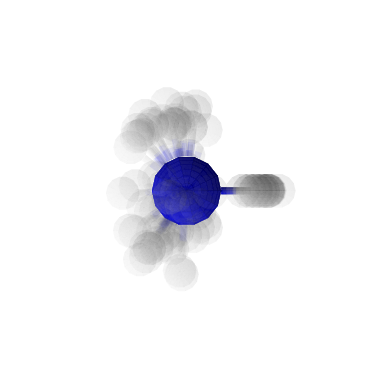

In [59]:
render_overlayed_systems(
    pbmetad_configs_monomer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=0.05,
    num_to_show=25
)

## Dimer

In [60]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        optimized_dimer
)

In [61]:
charges["E"] = 0.0
charges["F"] = 0.0

In [62]:
pbmetad_2b_size = 500

In [78]:
perform_pbmetad_simulation(
        "/expanse/projects/qstore/csd973/LAMMPS+plumed/LAMMPS-stable/bin/lmp_mpi",
        [optimized_monomer, optimized_water],
        num_configs=pbmetad_pool_size,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=structures.file("pbmetad_2b_traj.xyz"),
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=scratch.sub_directory("pbmetad_2b_scratch"),
        restart_path=restart.file("pbmetad_2b_restart")
)

Preparing PBMetaD Simulation...
Running PBMetaD Simulation...
Converting PBMetaD trajectory to XYZ...


In [79]:
pbmetad_configs_dimer = perform_fps(
        definition_dimer,
        optimized_dimer,
        modes_dimer,
        structures.file("pbmetad_2b_traj.xyz"),
        num_pool_configs=pbmetad_pool_size,
        num_phase1_input_configs=fps_phase1_size,
        approx_configs_to_select=fps_target_configs,
        fps_workdir=scratch.sub_directory("fps_2b_scratch"),
        restart_path=restart.sub_directory("fps_2b_restart"),
        num_threads=16
)

Number of permutations: 48
Beginning featurization...
Featurization progress: |====================================================================================================| - 500/500
Featurized 500 configurations.
Initializing round 1 FPS...
BallTree built!
Performing round 1 FPS...
Round 1 FPS iterations: |====================================================================================================| - 250/250
Completed round 1 fps, selected 250 configs, max distance: 1.4870831972849976
Number of permutations: 48
Beginning featurization...
Featurization progress: |====================================================================================================| - 500/500
Featurized 500 configurations.
Initializing round 2 FPS...
BallTree built!
Performing round 2 FPS...
Round 2 FPS iterations: 35
Completed round 2 fps, selected 35 configs.
Selected 285 total configs by FPS.


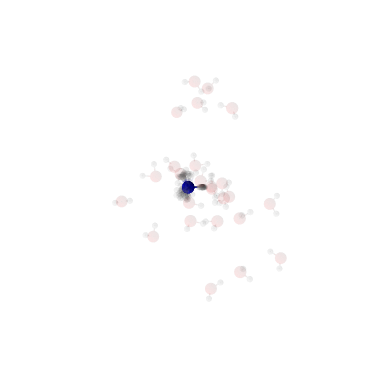

In [80]:
render_overlayed_systems(
    pbmetad_configs_dimer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=0.05,
    num_to_show=25
)

## Trimer

In [82]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        optimized_trimer
)

In [83]:
pbmetad_3b_size = 500

In [85]:
# structures.file("pbmetad_3b_traj.xyz").remove()
# scratch.sub_directory("pbmetad_3b_scratch").remove()
# restart.file("pbmetad_3b_restart").remove()
# scratch.sub_directory("fps_3b_scratch").remove()
# restart.sub_directory("fps_3b_restart")

In [86]:
perform_pbmetad_simulation(
        "/expanse/projects/qstore/csd973/LAMMPS+plumed/LAMMPS-stable/bin/lmp_mpi",
        [optimized_monomer, optimized_water, optimized_water],
        num_configs=pbmetad_pool_size,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=structures.file("pbmetad_3b_traj.xyz"),
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=scratch.sub_directory("pbmetad_3b_scratch"),
        restart_path=restart.file("pbmetad_3b_restart")
)

Preparing PBMetaD Simulation...
Running PBMetaD Simulation...
Converting PBMetaD trajectory to XYZ...


In [87]:
pbmetad_configs_trimer = perform_fps(
        definition_trimer,
        optimized_trimer,
        modes_trimer,
        structures.file("pbmetad_3b_traj.xyz"),
        num_pool_configs=pbmetad_pool_size,
        num_phase1_input_configs=fps_phase1_size,
        approx_configs_to_select=fps_target_configs,
        fps_workdir=scratch.sub_directory("fps_3b_scratch"),
        restart_path=restart.sub_directory("fps_3b_restart"),
        num_threads=16
)

Number of permutations: 192
Beginning featurization...
Featurization progress: |====================================================================================================| - 500/500
Featurized 500 configurations.
Initializing round 1 FPS...
BallTree built!
Performing round 1 FPS...
Round 1 FPS iterations: |====================================================================================================| - 250/250
Completed round 1 fps, selected 250 configs, max distance: 2.034507389941555
Number of permutations: 192
Beginning featurization...
Featurization progress: |====================================================================================================| - 500/500
Featurized 500 configurations.
Initializing round 2 FPS...
BallTree built!
Performing round 2 FPS...
Round 2 FPS iterations: 52
Completed round 2 fps, selected 52 configs.
Selected 302 total configs by FPS.


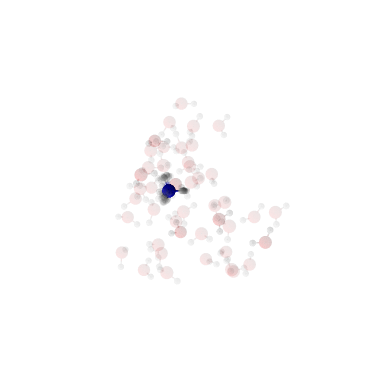

In [88]:
render_overlayed_systems(
    pbmetad_configs_trimer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=0.05,
    num_to_show=25
)